# LQ Approximation with `QuantEcon.py`

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import quantecon as qe

We consider a dynamic maximization problem with

* reward function $f(s, x)$,
* state transition function $g(s, x)$, and
* discount rate $\delta$,

where $s$ and $x$ are the state and the control variables, respectively
(we follow Miranda-Fackler in notation).

Let $(s^*, x^*)$ denote the steady state state-control pair,
and write
$f^* = f(s^*, x^*)$, $f_i^* = f_i(s^*, x^*)$, $f_{ij}^* = f_{ij}(s^*, x^*)$,
$g^* = g(s^*, x^*)$, and $g_i^* = g_i(s^*, x^*)$ for $i, j = s, x$.

First-order expansion of $g$ around $(s^*, x^*)$:
$$
\begin{align*}
g(s, x)
&\approx g^* + g_s^* (s - s^*) + g_x^* (x - x^*) \\
&= A \begin{pmatrix}1 \\ s\end{pmatrix} + B x,
\end{align*}
$$
where

* $A =
  \begin{pmatrix}
  1 & 0 \\
  g^* - \nabla g^{*\mathrm{T}} z^* & g_s^*
  \end{pmatrix}$,

* $B =
  \begin{pmatrix}
  0 \\ g_x^*
  \end{pmatrix}$

with $z^* = (s^*, x^*)^{\mathrm{T}}$ and $\nabla g^* = (g_s^*, g_x^*)^{\mathrm{T}}$.

Second-order expansion of $f$ around $(s^*, x^*)$:
$$
\begin{align*}
f(s, x)
&\approx f^* + f_s^* (s - s^*) + f_x^* (x - x^*) +
         \frac{1}{2} f_{ss}^* (s - s^*)^2 + f_{sx}^* (s - s^*) (x - x^*) +
         \frac{1}{2} f_{xx}^* (x - x^*)^2 \\
&= \begin{pmatrix}
   1 & s & x
   \end{pmatrix}
   \begin{pmatrix}
   f^* - \nabla f^{*\mathrm{T}} z^* + \frac{1}{2} z^{*\mathrm{T}} D^2 f^* z^* &
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*)^{\mathrm{T}} \\
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*) & \frac{1}{2} D^2 f^*
   \end{pmatrix}
   \begin{pmatrix}
   1 \\ s \\ x
   \end{pmatrix},
\end{align*}
$$
where
$\nabla f^* = (f_s^*, f_x^*)^{\mathrm{T}}$ and
$$
D^2 f^* =
\begin{pmatrix}
f_{ss}^* & f_{sx}^* \\
f_{sx}^* & f_{xx}^*
\end{pmatrix}.
$$

Let
$$
\begin{align*}
r(s, x)
&= -
   \begin{pmatrix}
   1 & s & x
   \end{pmatrix}
   \begin{pmatrix}
   f^* - \nabla f^{*\mathrm{T}} z^* + \frac{1}{2} z^{*\mathrm{T}} D^2 f^* z^* &
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*)^{\mathrm{T}} \\
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*) & \frac{1}{2} D^2 f^*
   \end{pmatrix}
   \begin{pmatrix}
   1 \\ s \\ x
   \end{pmatrix} \\
&= \begin{pmatrix}
   1 & s
   \end{pmatrix}
   R
   \begin{pmatrix}
   1 \\ s
   \end{pmatrix} +
   2 x N
   \begin{pmatrix}
   1 \\ s
   \end{pmatrix} +
   Q x,
\end{align*}
$$
where

* $R = -
  \begin{pmatrix}
  f^* - \nabla f^{*\mathrm{T}} z^* + \frac{1}{2} z^{*\mathrm{T}} D^2 f^* z^* &
  \frac{1}{2} [f_s^* - (f_{ss}^* s^* + f_{sx}^* x^*)] \\
  \frac{1}{2} [f_s^* - (f_{ss}^* s^* + f_{sx}^* x^*)] & \frac{1}{2} f_{ss}^*
  \end{pmatrix}$,

* $N = -
  \begin{pmatrix}
  \frac{1}{2} [f_x^* - (f_{sx}^* s^* + f_{xx}^* x^*)] & \frac{1}{2} f_{sx}^*
  \end{pmatrix}$.

* $Q = -\frac{1}{2} f_{xx}^*$.

Remarks:

* We are going to *minimize* the objective function.

In [2]:
def approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount):
    """
    Return an approximating LQ instance.
    
    Gradient of f: Df_star = np.array([f_s, f_x])
    Hessian of f: DDf_star = np.array([[f_ss, f_sx], [f_sx, f_xx]])
    Gradient of g: Dg_star = np.array([g_s, g_x])
    
    """
    n = 2
    k = 1
    sx_star = np.array([s_star, x_star])
    
    # (1, s)' R (1, s) + 2 x N (1, s) + x Q x
    Q = np.empty((k, k))
    R = np.empty((n, n))
    N = np.empty((k, n))
    R[0, 0] = -(f_star - Df_star @ sx_star + (sx_star @ DDf_star @ sx_star) / 2)
    R[1, 1], N[0, 1], N[0, 1], Q[0, 0] = -DDf_star.ravel() / 2
    R[1, 0], N[0, 0] = -(Df_star - DDf_star @ sx_star).ravel() / 2
    R[0, 1] = R[1, 0]
    
    # A (1, s) + B x + C w
    A = np.empty((n, n))
    B = np.empty((n, k))
    C = np.zeros((n, 1))
    A[0, 0], A[0, 1], B[0, 0] = 1, 0, 0
    A[1, 0] = g_star - Dg_star @ sx_star
    A[1, 1], B[1, 0] = Dg_star.ravel()
    
    lq = qe.LQ(Q, R, A, B, C, N, beta=discount)
    return lq

In [3]:
def evaluate_path(lq, s_path, x_path):
    ts_length = x_path.shape[1]
    v = 0.
    d = 1.
    for t in range(ts_length):
        r = s_path[:, t] @ (lq.R @ s_path[:, t]) + \
            2 * (x_path[0, t] * (lq.N @ s_path[:, t])) + x_path[0, t] * lq.Q * x_path[0, t]
        v += (r * d)[0, 0]
        d *= lq.beta
    return v

## Deterministic Optimal Growth Model

We consider the following simple optimal growth model:

* $f(s, x) = \log (s - x)$,
* $g(s, x) = x^{\alpha}$.

In [4]:
alpha = 0.5
discount = 0.9

Function definitions:

In [5]:
f = lambda s, x: np.log(s - x)
f_s = lambda s, x: (s - x)**(-1)
f_x = lambda s, x: -f_s(s, x)
f_ss = lambda s, x: -(s - x)**(-2)
f_sx = lambda s, x: -f_ss(s, x)
f_xx = lambda s, x: f_ss(s, x)

g = lambda s, x: x**alpha
g_s = lambda s, x: 0
g_x = lambda s, x: alpha * x**(alpha - 1)

Steady state:

In [6]:
x_star = (discount * alpha)**(1 / (1 - alpha))
s_star = x_star**alpha
s_star, x_star

(0.45, 0.2025)

`(s_star, x_star)` satisfies the Euler equations:

In [7]:
f_x(s_star, x_star) + discount * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

0.0

Construct $f^*$, $\nabla f^*$, $D^2 f^*$, $g^*$, and $\nabla g^*$:

In [8]:
f_star = f(s_star, x_star)
Df_star = np.array([f_s(s_star, x_star), f_x(s_star, x_star)])
DDf_star = np.array([[f_ss(s_star, x_star), f_sx(s_star, x_star)],
                     [f_sx(s_star, x_star), f_xx(s_star, x_star)]])
g_star = g(s_star, x_star)
Dg_star = np.array([g_s(s_star, x_star), g_x(s_star, x_star)])

## LQ Approximation

Generate an LQ instance that approximates our dynamic optimization problem:

In [9]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)

In [10]:
lq.Q

array([[ 8.1624324]])

In [11]:
lq.R

array([[ 2.8963447 , -4.04040404],
       [-4.04040404,  8.1624324 ]])

In [12]:
lq.N

array([[ 4.04040404, -8.1624324 ]])

In [13]:
lq.A

array([[ 1.   ,  0.   ],
       [ 0.225,  0.   ]])

In [14]:
lq.B

array([[ 0.        ],
       [ 1.11111111]])

In [15]:
lq.beta

0.9

In [16]:
np.linalg.eig(lq.R)

(array([  0.706756 ,  10.3520211]), array([[-0.87919749,  0.47645752],
        [-0.47645752, -0.87919749]]))

## Solution by `LQ.stationary_values`

Solve the LQ problem:

In [17]:
P, F, d = lq.stationary_values()
P, F, d

(array([[ 8.96344697,  0.        ],
        [ 0.        ,  0.        ]]), array([[ 0.495, -1.   ]]), 0.0)

The optimal value function (of the LQ minimization problem):

In [18]:
V = lambda s: np.array([1, s]) @ P @ np.array([1, s]) + d

The value at $s^*$:

In [19]:
V(s_star)

8.9634469697339139

The optimal policy function:

In [20]:
X = lambda s: -F @ np.array([1, s])

The optimal choice at $s^*$:

In [21]:
X(s_star)

array([-0.045])

This is different from $x^*$:

In [22]:
x_star

0.2025

### State-control paths

In [23]:
ts_length = 300
s_path, x_path, _ = lq.compute_sequence([1, s_star+1], ts_length)

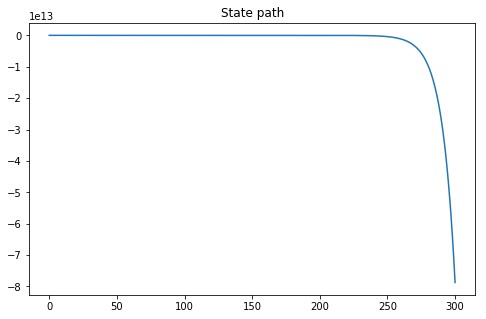

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(s_path[1, :])
ax.set_title('State path')
plt.show()

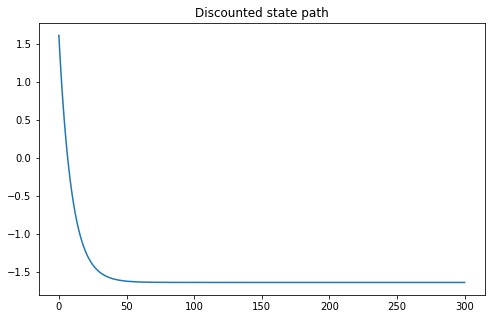

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(s_path[1, :] * np.array([lq.beta**(t-1) for t in range(ts_length+1)]))
ax.set_title('Discounted state path')
plt.show()

In [26]:
evaluate_path(lq, s_path, x_path)

9.0227763743511638

In [27]:
V(s_star)

8.9634469697339139

Stationary path:

In [28]:
s_star_path = np.empty((2, ts_length+1))
s_star_path[0], s_star_path[1] = 1, s_star

x_star_path = np.empty((1, ts_length))
x_star_path[0] = x_star

In [29]:
evaluate_path(lq, s_star_path, x_star_path)

13.963446969733655

In [30]:
-f_star / (1 - lq.beta)

13.963446969733925

### Eigenvalues of `G = A - B @ F`

In [31]:
G = lq.A - lq.B @ F
w, v = np.linalg.eig(G)
w

array([ 1.11111111,  1.        ])

In [32]:
w * lq.beta

array([ 1. ,  0.9])

## Solution by `scipy.linalg.solve_discrete_are`

In [33]:
A0, B0 = np.sqrt(lq.beta) * lq.A, np.sqrt(lq.beta) * lq.B
P_sp = scipy.linalg.solve_discrete_are(A0, B0, lq.R, lq.Q, s=lq.N.reshape(2, 1))
P_sp

array([[ 15.94691804,  -2.38751148],
       [ -2.38751148,   0.81624324]])

In [34]:
def compute_F(P, A, B, Q, N, beta):
    S1 = Q + beta * np.dot(B.T, np.dot(P, B))
    S2 = beta * np.dot(B.T, np.dot(P, A)) + N
    F = np.linalg.solve(S1, S2)
    return F

In [35]:
F_sp = compute_F(P_sp, lq.A, lq.B, lq.Q, lq.N, lq.beta)
F_sp

array([[ 0.2025, -0.9   ]])

In [36]:
V_sp = lambda s: np.array([1, s]) @ P_sp @ np.array([1, s])

In [37]:
V_sp(s_star)

13.963446969733827

In [38]:
-f_star / (1 - lq.beta)

13.963446969733925

In [39]:
X_sp = lambda s: -F_sp @ np.array([1, s])

In [40]:
X_sp(s_star)

array([ 0.2025])

In [41]:
x_star

0.2025

In [42]:
G_sp = lq.A - lq.B @ F_sp
G_sp

array([[  1.00000000e+00,   0.00000000e+00],
       [ -3.16413562e-15,   1.00000000e+00]])

In [43]:
w, v = np.linalg.eig(G_sp)
w

array([ 1.,  1.])